# cifar10 softmax nn

## imports

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import pickle

## data
This is CIFAR-10 dataset. Extraction directions are provided on [this](http://www.cs.toronto.edu/~kriz/cifar.html) website.

In [3]:
def unpickle(file):
    with open(file, "rb") as f:
        data_map = pickle.load(f, encoding="bytes")
    return data_map

In [4]:
data_batch_1 = unpickle("../my_datasets/cifar-10-batches-py/data_batch_1")

In [5]:
#datapoint
data_batch_1[b"data"][0].shape

(3072,)

In [6]:
#label
data_batch_1[b"labels"][0]

6

In [7]:
img_dim = [32, 32]

The images currently aren't in a render-ready form. From the website provided above: "The next 3072 bytes are the values of the pixels of the image. The first 1024 bytes are the red channel values, the next 1024 the green, and the final 1024 the blue. The values are stored in row-major order, so the first 32 bytes are the red channel values of the first row of the image."

[Matplotlib](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) will required an m\*n\*3, where m is the horizontal dimension, n is the vertical dimension, and 3 is the number of color channels.

In [8]:
#plt.imshow(data_batch_1[b"data"][0].reshape(img_dim))

We'll define a function below to get the image ready.

In [9]:
int(len(data_batch_1[b"data"][0]) / 3)

1024

In [10]:
def mutate_img(arr, flatten=False):
    #color channels
    color_channels = 3
    #offset between r->g, g->b (constant, w*h)
    color_offset = int(len(arr) / color_channels)
    #image pixel 0 (r0, g0, b0) is at indices flat_img[0:3]
    #image pixel i (ri, gi, bi) is at indices flat_image[i*3:i*3 + 3]
    flat_img = []
    for i in range(color_offset):
        for j in range(color_channels):
            flat_img.append(arr[i + j*color_offset])
    
    #reshape if necessary
    dim = int(color_offset ** .5)
    result = np.asarray(flat_img)
    if not flatten:
        result = result.reshape([dim, dim, color_channels])
    #return image
    return result

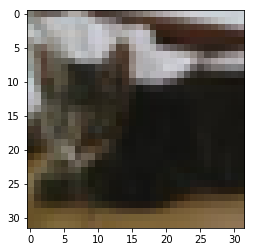

In [11]:
for i in range(10):
    plt.imshow(mutate_img(data_batch_1[b"data"][i]))

We'll create a small helper function to display multiple images ([source](https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa)).

In [12]:
def show_multiple_images(rows=8, cols=8):
    idxs = []
    fig = plt.figure(figsize=(6, 6))
    for i in range(1, rows*cols + 1):
        #get image
        img_ls = data_batch_1[b"data"]
        idxs.append(np.random.randint(low=0, high=len(img_ls)))
        img = mutate_img(img_ls[idxs][-1])
        
        #plot
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)
    plt.show()

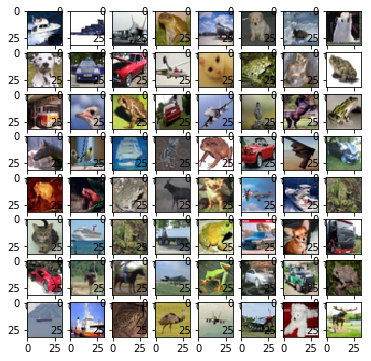

In [13]:
show_multiple_images()

### one-hot encoding the data
The classes in the dataset are represented as integers.

In [14]:
np.unique(np.asarray(data_batch_1[b"labels"]))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

Let's one-hot encode the data so we can use a softmax probabilistic estimator.

In [15]:
ohe = OneHotEncoder().fit(np.asarray(data_batch_1[b"labels"]).reshape(-1, 1))

In [16]:
ohe.n_values_

array([10])

In [17]:
np.asarray(data_batch_1[b"labels"][:5]).reshape(-1, 1)

array([[6],
       [9],
       [9],
       [4],
       [1]])

In [18]:
ohe.transform(np.asarray(data_batch_1[b"labels"][:5]).reshape(-1, 1)).toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

## one-hot encoding all labels

In [19]:
y_ohe = ohe.transform(np.asarray(data_batch_1[b"labels"]).reshape(-1, 1)).toarray()
y_ohe[:10]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

## converting images to black and white
At this point in time I don't know how to deal with color images, so instead I'll convert these images to black and white using the [luminosity](https://www.johndcook.com/blog/2009/08/24/algorithms-convert-color-grayscale/) method 0.21 R + 0.72 G + 0.07 B.

In [20]:
data_batch_1[b"data"].shape

(10000, 3072)

In [21]:
len(data_batch_1[b"data"])

10000

In [22]:
black_and_white_data = []
data = data_batch_1[b"data"]
pixels = img_dim[0] * img_dim[1]
#iterate over each image
for i in range(len(data)):
    black_and_white_data.append([])
    img = black_and_white_data[-1]
    #iterate over each pixel RGB
    for j in range(pixels):
        red = data[i][0*pixels + j]
        green = data[i][1*pixels + j]
        blue = data[i][2*pixels + j]
        img.append(.21 * red + .72 * green + .07 * blue)

In [23]:
#convert to numpy array
black_and_white_data = np.asarray(black_and_white_data)

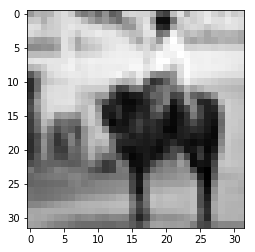

In [24]:
plt.imshow(black_and_white_data[11].reshape(img_dim), cmap="gist_gray")

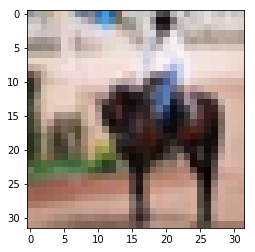

In [25]:
plt.imshow(mutate_img(data_batch_1[b"data"][11]))

## splitting data
Here we'll split the data into training and testing sets.

In [26]:
test_size = .2
random_state = 0

In [27]:
x_train, x_test, y_train, y_test = train_test_split(
    black_and_white_data,
    y_ohe,
    test_size=test_size,
    random_state=random_state
)

## placeholders and variables (input layer)

In [28]:
num_classes = ohe.n_values_[0]
num_classes

10

In [29]:
img_dim[0] * img_dim[1]

1024

In [30]:
#flattened images
x = tf.placeholder(tf.float32, shape=[None, pixels])

## hidden layers

h1

In [32]:
h1_out_dim = int(pixels / 2)
h1_out_dim

512

In [34]:
w1 = tf.Variable(tf.zeros(shape=[pixels, h1_out_dim]))
b1 = tf.Variable(tf.zeros(shape=[h1_out_dim]))
h1 = tf.add(tf.matmul(x, w1), b1)

h2

In [73]:
h2_out_dim = int(h1_out_dim / 2)
h2_out_dim

256

In [74]:
w2 = tf.Variable(tf.zeros(shape=[h1_out_dim, h2_out_dim]))
b2 = tf.Variable(tf.zeros(shape=[h2_out_dim]))
h2 = tf.add(tf.matmul(h1, w2), b2)

h3

In [75]:
h3_out_dim = int(h2_out_dim / 2)
h3_out_dim

128

In [76]:
w3 = tf.Variable(tf.zeros(shape=[h2_out_dim, h3_out_dim]))
b3 = tf.Variable(tf.zeros(shape=[h3_out_dim]))
h3 = tf.add(tf.matmul(h2, w3), b3)

## output layer

In [77]:
output_out_dim = num_classes
output_out_dim

10

In [78]:
#h2
w4 = tf.Variable(tf.zeros(shape=[h3_out_dim, output_out_dim]))
b4 = tf.Variable(tf.zeros([output_out_dim]))
y_pred = tf.add(tf.matmul(h3, w4), b4)

## loss

In [101]:
y_true = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])
cross_entropy = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(
        labels=y_true,
        logits=y_pred
    )
)

## batching
Below we'll define a function to grab batches of data. This function will have the option for sampling with **and** without replacement.

In [40]:
#use this data for testing batching
data_x = [i for i in range(10)]
data_x

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [41]:
#use this data for testing batching
data_y = list(map(lambda x: x + 2, data_x))
data_y

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [42]:
np.random.randint(low=0, high=len(data_x), size=10)

array([5, 0, 0, 0, 6, 7, 1, 1, 2, 1])

In [43]:
some_data = [1,2,3]
np.random.shuffle(some_data)
some_data

[1, 3, 2]

In [44]:
def get_batches(x, y, batch_size, replacement=True):
    #if batch elements can be copies of one another (duplicates, triplicates, etc.)
    batch_x = []
    batch_y = []
    if replacement:
        indices = np.random.randint(low=0, high=len(x), size=batch_size)
    else:
        indices = [i for i in range(len(x))]
        np.random.shuffle(indices)
        indices = indices[:batch_size]
    for i in indices:
        batch_x.append(x[i])
        batch_y.append(y[i])
    return batch_x, batch_y

In [45]:
get_batches(
    x=data_x,
    y=data_y,
    batch_size=5,
    replacement=False
)

([5, 7, 8, 3, 1], [7, 9, 10, 5, 3])

## hyperparameters

In [132]:
#epochs * batch_size = total training images out of 10000
epochs = 3
batch_size = 16
learning_rate = 0.001

## optimizer

In [133]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
train = optimizer.minimize(cross_entropy)

## session

In [134]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    #init global variables
    sess.run(init)
    
    #train
    for step in range(epochs):
        #the image data is a pretty big argument to be passing around
        #as a function parameter...but we should be ok here (easy
        #resolution otherwise)
        batch_x, batch_y = get_batches(
            x=x_train,
            y=y_train,
            batch_size=batch_size,
            replacement=True
        )
        #execute training node
        sess.run(train, feed_dict={
            x: batch_x,
            y_true: batch_y
        })
        
    #evaluate
    preds = tf.argmax(y_pred, axis=1)
    reals = tf.argmax(y_true, axis=1)
    correct_preds = tf.equal(preds, reals)
    #accuracy
    acc = tf.reduce_mean(tf.cast(correct_preds, tf.float32))
    
    #output accuracy
    print(sess.run(acc, feed_dict={
        x: x_test,
        y_true: y_test
    }))
    
    #get predictions
    preds = sess.run(preds, feed_dict={
        x: x_test
    })
    reals = sess.run(reals, feed_dict={
        y_true: y_test
    })

0.0955


## analyze outputs

In [131]:
preds[:100]

array([7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7], dtype=int64)